# `politifact_scrap` - ML

In [3]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Helper functions

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def plot_learning_curve(model, Name, X_train, y_train):

    train_sizes = np.linspace(0.1, 1, 15)
    
    train_sizes, train_scores, test_scores = learning_curve(
                  model, X_train, y_train, 
                  train_sizes = train_sizes,
                  cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.grid()
    plt.title(f"Model - {Name}")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "CV Test score")
    plt.legend(loc="best")
    plt.show()


def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)

def get_scores(model, model_name, X_train, y_train, X_test, y_test):
    
    # Cross Validation
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring = scoring)

    acc = cv_results['test_accuracy'].mean()
    recall = cv_results['test_recall'].mean()
    precision = cv_results['test_precision'].mean()
    f1 = cv_results['test_f1'].mean()
    
    print('-'*80)
    print(f"{model_name} - CV scores: ")
    print('-'*80)
    print(f"Acc : {acc:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"f1: {f1:.2f}")
    
    # Test evaluation
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    print('-'*80)
    print(f"{model_name} - test scores: ")
    binary_metrics(y_test, y_preds)
    
    return acc, recall, precision, f1

## Loading `politifact_scrap.csv` file from GCP Buket

In [4]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data shape: {data.shape}")
print('-'*80)
print('-'*80)
print(data['category'].value_counts()/len(data)*100)
print('-'*80)
print(data['category2'].value_counts()/len(data)*100)
print('-'*80)

--------------------------------------------------------------------------------
data shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [4]:
# data[data['text'].str.contains("Google Pinterest")]

In [5]:
data.head()

,author,statement,source,date,target,category_cat,category,category2
0,Emily Tian,“Washington public school forces unvaccinated ...,Facebook posts,"August 25, 2021",half-true,2.0,1,0
1,Samantha Putterman,75 doctors in South Florida walked out in prot...,Instagram posts,"August 25, 2021",false,4.0,1,1
2,Gabrielle Settles,"“It is the vaccinated, NOT the unvaccinated, s...",Facebook posts,"August 25, 2021",false,4.0,1,1
3,Tom Kertscher,“80% of women who have been jabbed have lost t...,Facebook posts,"August 24, 2021",false,4.0,1,1
4,Ciara O'Rourke,“Pfizer CEO has not yet had vaccine.”,Instagram posts,"August 24, 2021",false,4.0,1,1


## Preprocessing

In [6]:
import string

def preprocessing(text):
    for punctuation in string.punctuation: 
        text = text.replace(punctuation, ' ') 
    return text
    
X = data['statement'].apply(preprocessing).copy()
y = data['category2'].copy()

print('-'*80)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print('-'*80)
print(f"Original text: {data['statement'][0]}")
print(f"Clean text: {X[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X shape: (19826,)
y shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports 
--------------------------------------------------------------------------------


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print('-'*80)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_train.sum()/len(y_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_test.sum()/len(y_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_train shape: (15860,)
y_train shape: (15860,)
--------------------------------------------------------------------------------
X_test shape: (3966,)
y_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_vec_df = pd.DataFrame(X_train_vec.toarray(), columns = vectorizer.get_feature_names())

print('-'*80)
print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")
print('-'*80)
print(f"Number of stop words: {len(vectorizer.get_stop_words())}")
# print(vectorizer.get_stop_words())
print('-'*80)
print(X_train_vec_df.head())
print('-'*80)

--------------------------------------------------------------------------------
X_train_vec shape: (15860, 15063)
X_test_vec shape: (3966, 15063)
--------------------------------------------------------------------------------
Number of stop words: 318
--------------------------------------------------------------------------------
    00  000  014   02  024  029   03  033   04   05  ...  zoning  zoo  zoom  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0   0.0   

   zpass  zuber  zucker  zuckerberg  zyphr  único  ḍozen  
0    0.0    0.0     0.0         0.0    0.0    0.0    0.0  
1    0.0    0.0     0.0         0.0    0.0    0.0    0.0  
2    0.0    0

## Logistic Regression - Baseline model

--------------------------------------------------------------------------------
Logistic Reg - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.80
Precision: 0.64
f1: 0.71
--------------------------------------------------------------------------------
Logistic Reg - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.78
Precision: 0.64
f1: 0.71
--------------------------------------------------------------------------------


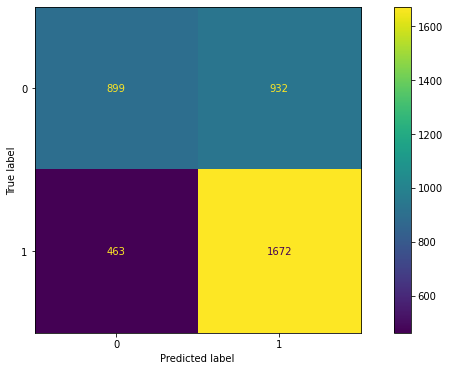

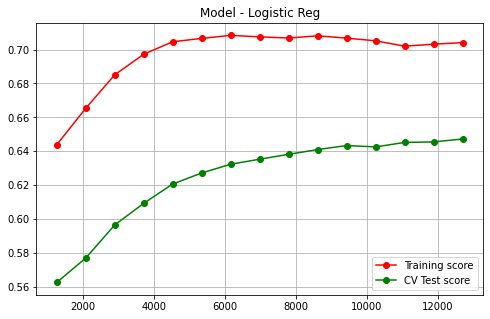

In [39]:
from sklearn.linear_model import LogisticRegression   

log_model = LogisticRegression(max_iter=1000, C=0.2, n_jobs=-1)
acc, recall, precision, f1 = get_scores(log_model, 'Logistic Reg', X_train_vec, y_train, X_test_vec, y_test)

plot_confusion_matrix(log_model, X_test_vec, y_test, values_format='d');

plot_learning_curve(log_model, 'Logistic Reg', X_train_vec, y_train)

## Naive Bayes

--------------------------------------------------------------------------------
Naive Bayes - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.69
Precision: 0.67
f1: 0.68
--------------------------------------------------------------------------------
Naive Bayes - test scores: 
--------------------------------------------------------------------------------
Acc: 0.64
Recall: 0.67
Precision: 0.67
f1: 0.67
--------------------------------------------------------------------------------


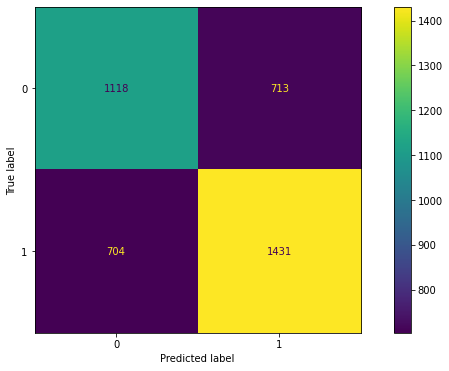

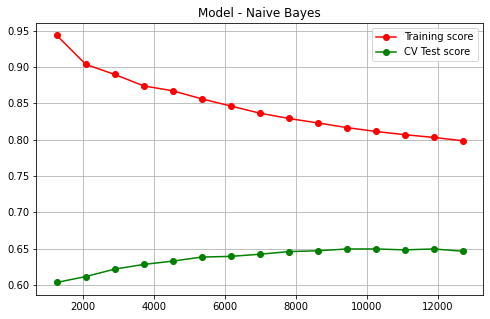

In [14]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
acc, recall, precision, f1 = get_scores(nb_model, 'Naive Bayes', X_train_vec, y_train, X_test_vec, y_test)

plot_confusion_matrix(nb_model, X_test_vec, y_test, values_format='d');

plot_learning_curve(nb_model, 'Naive Bayes', X_train_vec, y_train)

## SVM

--------------------------------------------------------------------------------
SVM - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.74
Precision: 0.66
f1: 0.70
--------------------------------------------------------------------------------
SVM - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.71
Precision: 0.66
f1: 0.69
--------------------------------------------------------------------------------


KeyboardInterrupt: 

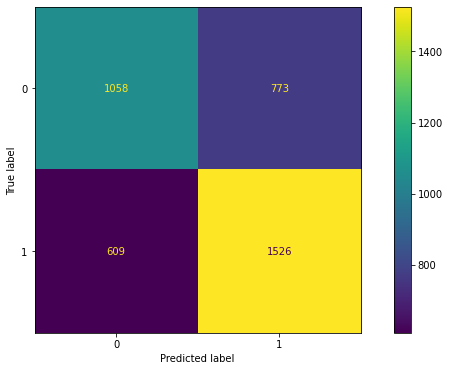

In [15]:
from sklearn.svm import SVC

svm_model = SVC()
acc, recall, precision, f1 = get_scores(svm_model, 'SVM', X_train_vec, y_train, X_test_vec, y_test)

plot_confusion_matrix(svm_model, X_test_vec, y_test, values_format='d');

plot_learning_curve(svm_model, 'SVM', X_train_vec, y_train)

## Random Forest

--------------------------------------------------------------------------------
RandomForest - CV scores: 
--------------------------------------------------------------------------------
Acc : 0.65
Recall: 0.71
Precision: 0.66
f1: 0.69
--------------------------------------------------------------------------------
RandomForest - test scores: 
--------------------------------------------------------------------------------
Acc: 0.65
Recall: 0.68
Precision: 0.67
f1: 0.68
--------------------------------------------------------------------------------


KeyboardInterrupt: 

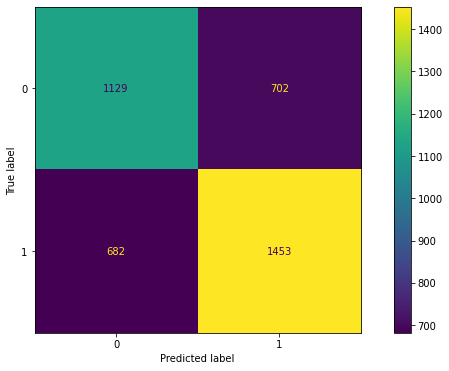

In [16]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
acc, recall, precision, f1 = get_scores(forest_model, 'RandomForest', X_train_vec, y_train, X_test_vec, y_test)

plot_confusion_matrix(forest_model, X_test_vec, y_test, values_format='d');

plot_learning_curve(forest_model, 'RandomForest', X_train_vec, y_train)

## Fine Tuning

In [23]:
pipeline.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()), ('log_reg', LogisticRegression())],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'log_reg': LogisticRegression(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'log_reg__C': 1.0,
 'log_reg__class_weight': None,
 'log_reg__dual': False,
 'log_reg__fit_intercept': True,
 'log_reg__intercept_scaling': 1,
 'log_reg__l1_ratio': None,
 'log_reg__max_iter': 100,
 'log_reg__multi_clas

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('log_reg', LogisticRegression(max_iter=1000)),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'tfidf__min_df': (0.05, 0.1),
    'tfidf__max_df': (0.75, 1),
    'log_reg__C': (0.01, 0.1, 1, 10)
}

grid_search = GridSearchCV(pipeline, 
                           parameters, 
                           n_jobs=-1, 
                           scoring="accuracy", 
                           refit=True, 
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/feature_extraction/text.py", line 1846, in fit_transform
    X = super().fit_transform(raw_documents)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/feature_extraction/text.py", line 1221, in fit_transform
    X, self.stop_words_ = self._limit_features(X, vocabulary,
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/feature_extraction/text.py", line 1092, in _limit_features
    raise ValueError("After pruning, no terms remain. Try a lower"
ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test par

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
 

/Users/julienseguy/.pyenv/versions/3.8.6/envs/StopFAIke/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.59041614        nan        nan 0.54300126        nan        nan
        nan        nan        nan        nan        nan        nan
 0.59066835        nan        nan 0.54300126        nan        nan
        nan        nan        nan        nan        nan        nan
 0.59079445        nan        nan 0.54300126        nan        nan
        nan        nan        nan        nan        nan        nan
 0.59066835        nan        nan 0.54300126        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('log_reg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'log_reg__C': (0.01, 0.1, 1, 10),
                         'tfidf__max_df': (0.75, 1),
                         'tfidf__min_df': (0.05, 0.1),
                         'tfidf__ngram_range': ((1, 1), (2, 2), (3, 3))},
             scoring='accuracy', verbose=1)

In [35]:
grid_search.best_score_

0.5907944514501892

In [36]:
grid_search.best_params_

{'log_reg__C': 1,
 'tfidf__max_df': 0.75,
 'tfidf__min_df': 0.05,
 'tfidf__ngram_range': (1, 1)}